# Passive Compartmental Models

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd

In [67]:
# setting parameters
d = 0.5 # micrometers
r_m = 40 # kiloOhms cm squared
r_i = 200 # Ohms cm

C = 1 # uF/cm^2

In [138]:
# compute length constant
lambda_sim = np.sqrt((((r_m*1e3)/1e-8) / (r_i/1e-4)) * ((d) / 4))
print(f"Length constant: {lambda_sim} micrometers")

cable_length = 2*lambda_sim  # micrometers
dx = 0.05*lambda_sim  # micrometers
print(dx)

Length constant: 500.0 micrometers
25.0


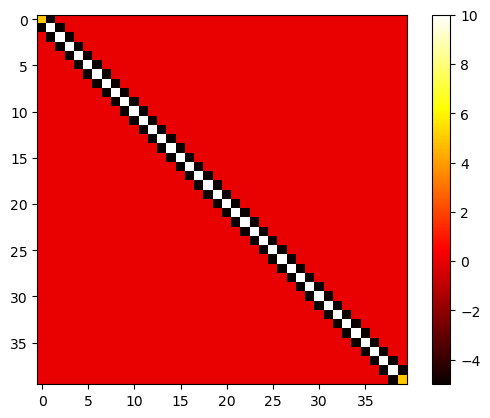

In [151]:
# cable equation
def get_m(g_i, g_m, lam, dx, comps):
    #print(g_i, g_m, lam, dx, comps)
    # create a matrix m
    m = np.zeros((comps, comps))
    for i in range(comps):
        for j in range(comps):
            if (i == 0 and j == 0) or (i == comps-1 and j == comps-1):
                m[i, j] = g_i + g_m
            elif i != 0 and i != comps-1 and i == j:
                m[i, j] = 2 * g_i + g_m
            elif abs(i - j) == 1:
                m[i, j] = -g_i 
            else:
                m[i, j] = 0
    return m

def dV_dt(V, I_inj, g_m, C, lambda_sim, dx, comps):
    m = get_m(g_i, g_m, lambda_sim, dx, comps)
    # compute dV/dt by matrix multiplication of m and V over time (ODE)
    dv_dt = -(m @ V) / C + I_inj / C
    return m, dv_dt

# plot m
plt.imshow(get_m(g_i, 0, lambda_sim, dx, comps), cmap='hot', interpolation='nearest')
plt.colorbar()  

In [152]:
# run simulation
I_inj = np.zeros(comps)  # no injected current
I_inj[0] = 1  # inject current at the beginning
dt = 0.01  # ms
t_max = 100  # ms
time = np.arange(0, t_max, dt)
comps = int(cable_length / dx)
V = np.zeros((comps, len(time)))  # initialize voltage matrix
# V[:, 0] = 0  # initial condition: V=0 everywhere
g_m = 0.025 # mS/cm^2
g_i = 5 # mS/cm

In [153]:
# simulate over time
def simulate_cable(V, I_inj, g_m, C, lambda_sim, dx, comps, time, dt):
    for t in range(1, len(time)):
        m, dV = dV_dt(V[:, t-1], I_inj, g_m, C, lambda_sim, dx, comps)
        V[:, t] = V[:, t-1] + dV * dt
    return V

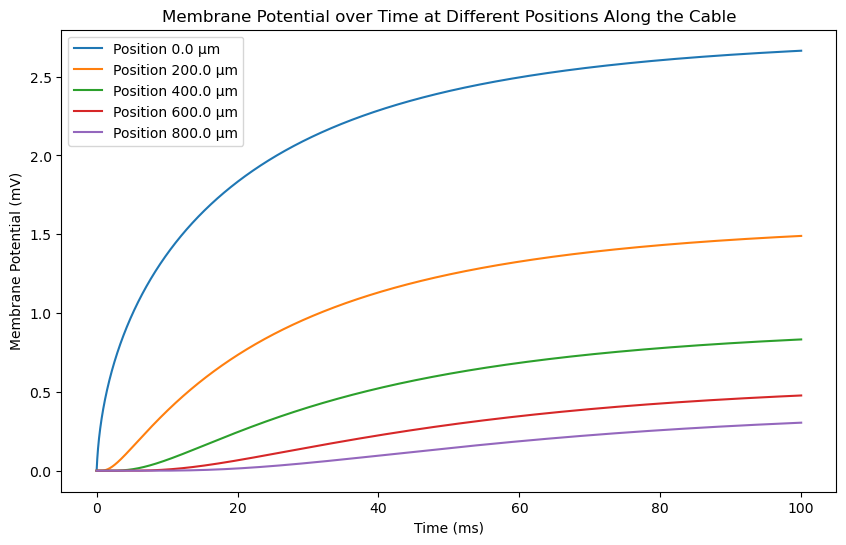

In [154]:
# run
V = simulate_cable(V, I_inj, g_m, C, lambda_sim, dx, comps, time, dt)

# Plot results
plt.figure(figsize=(10, 6))
for i in range(0, comps, int(comps/5)):
    plt.plot(time, V[i, :], label=f'Position {i*dx:.1f} µm')
plt.xlabel('Time (ms)')
plt.ylabel('Membrane Potential (mV)')
plt.title('Membrane Potential over Time at Different Positions Along the Cable')
plt.legend()

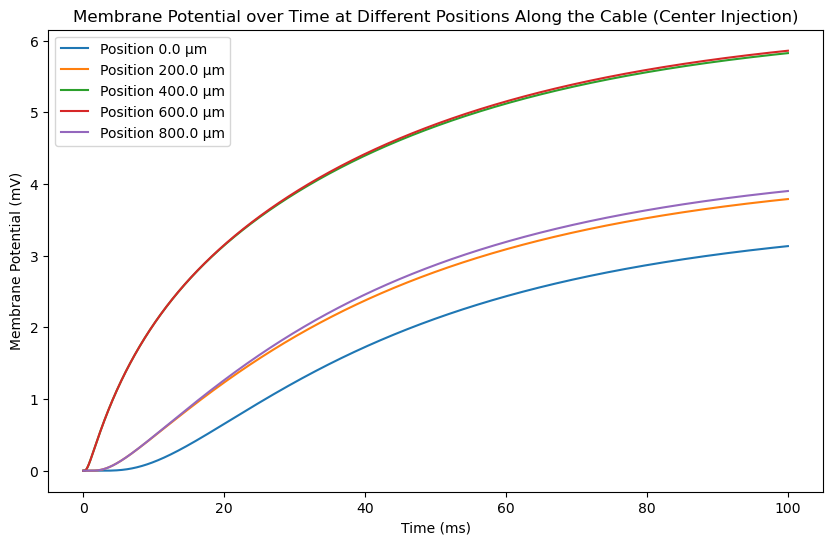

In [155]:
# Inject into center of cable
I_inj = np.zeros(comps)  # no injected current
I_inj[comps//2] = 5  # inject current at the center

# simulate again
V = np.zeros((comps, len(time)))  # re-initialize voltage matrix
V = simulate_cable(V, I_inj, g_m, C, lambda_sim, dx, comps, time, dt)

# Plot results for center injection
plt.figure(figsize=(10, 6))
for i in range(0, comps, int(comps/5)):
    plt.plot(time, V[i, :], label=f'Position {i*dx:.1f} µm')
plt.xlabel('Time (ms)')
plt.ylabel('Membrane Potential (mV)')
plt.title('Membrane Potential over Time at Different Positions Along the Cable (Center Injection)')
plt.legend()

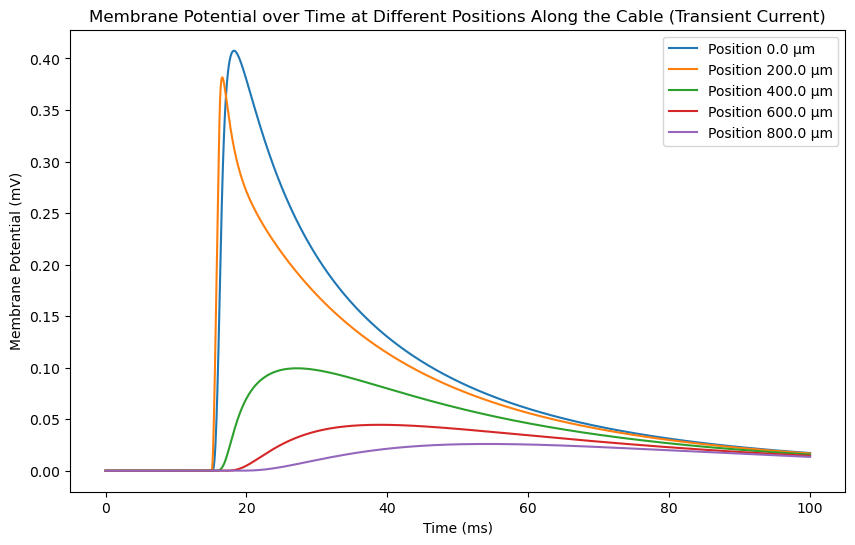

In [156]:
# transient current lasting 1 ms
I_inj = np.zeros(comps)  # no injected current
dt = 0.01  # ms
t_max = 100  # ms
time = np.arange(0, t_max, dt)
comps = int(cable_length / dx)
V = np.zeros((comps, len(time)))  # initialize voltage matrix
#V[:, 0] = 0  # initial condition: V=0 everywhere
g_m = 0.025 # mS/cm^2
g_i = 5 # mS/cm     
# simulate over time with transient current
for t in range(1, len(time)):
    if time[t] > 15 and time[t] <= 16:
        I_inj[5] = 5
    if time[t] > 16:
        I_inj[5] = 0  # turn off current after 1 ms
    m, dV = dV_dt(V[:, t-1], I_inj, g_m, C, lambda_sim, dx, comps)
    V[:, t] = V[:, t-1] + dV * dt   
# Plot results for transient current
plt.figure(figsize=(10, 6))
for i in range(0, comps, int(comps/5)):
    plt.plot(time, V[i, :], label=f'Position {i*dx:.1f} µm')
plt.xlabel('Time (ms)')
plt.ylabel('Membrane Potential (mV)')
plt.title('Membrane Potential over Time at Different Positions Along the Cable (Transient Current)')
plt.legend()

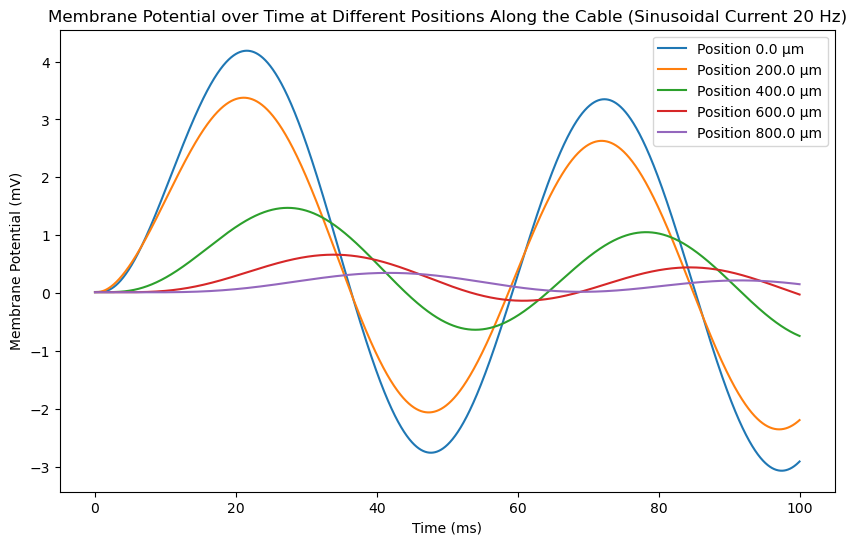

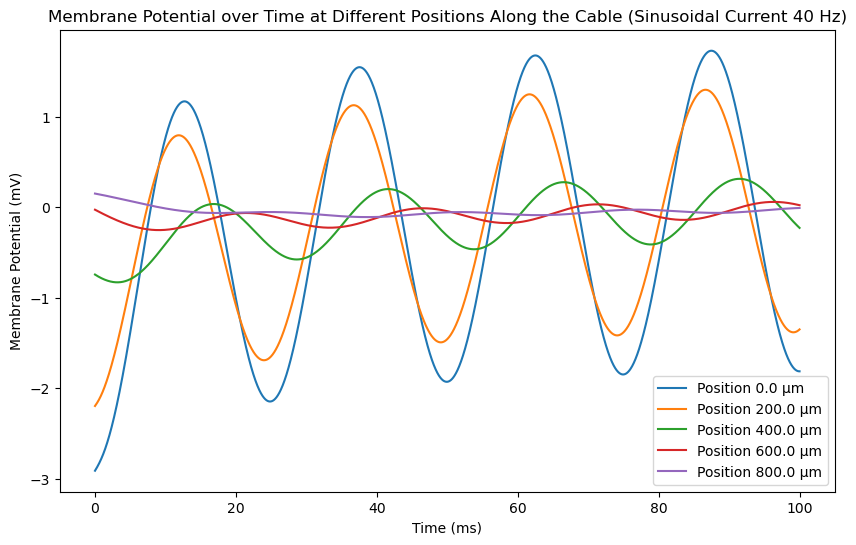

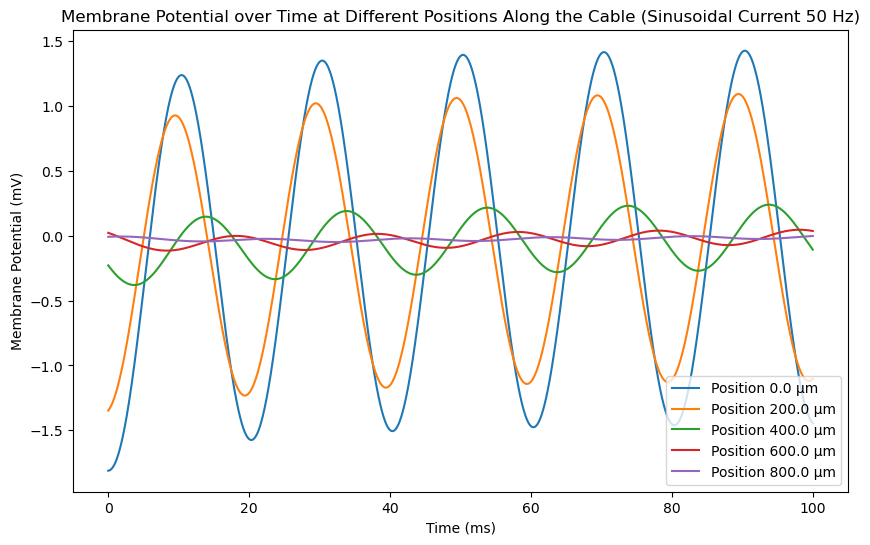

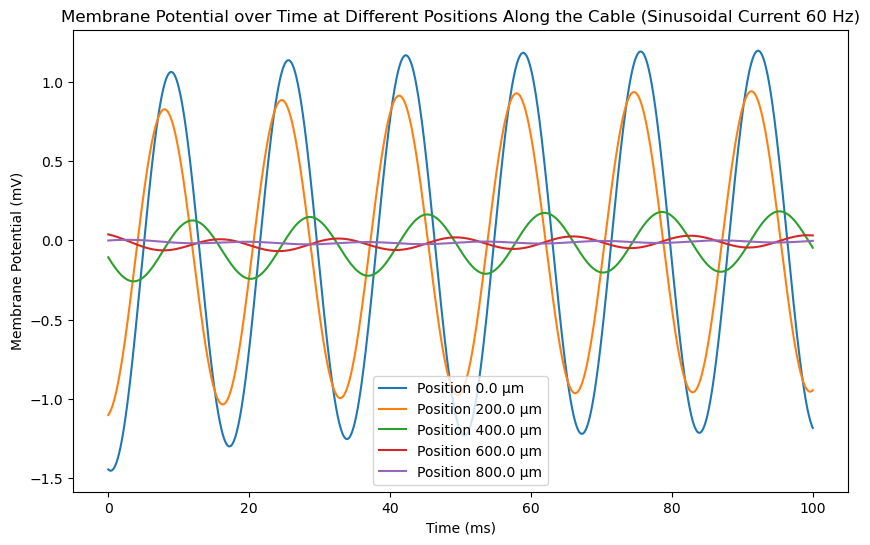

In [157]:
# Inject sinusoidal current of different temporal frequencies
I_inj = np.zeros(comps)  # no injected current
freqs = [20, 40, 50, 60]  # frequencies in Hz
for freq in freqs:
    for t in range(len(time)):
        I_inj[5] = 5 * math.sin(2 * math.pi * freq * time[t] / 1000)  # convert ms to s
        m, dV = dV_dt(V[:, t-1], I_inj, g_m, C, lambda_sim, dx, comps)
        V[:, t] = V[:, t-1] + dV * dt   
    # Plot results for sinusoidal current
    plt.figure(figsize=(10, 6))
    for i in range(0, comps, int(comps/5)):
        plt.plot(time, V[i, :], label=f'Position {i*dx:.1f} µm')
    plt.xlabel('Time (ms)')
    plt.ylabel('Membrane Potential (mV)')
    plt.title(f'Membrane Potential over Time at Different Positions Along the Cable (Sinusoidal Current {freq} Hz)')
    plt.legend()

In [158]:
# count peaks across different frequencies
peak_counts = {}
for freq in freqs:
    count = 0
    for t in range(1, len(time)-1):
        if V[5, t] > V[5, t-1] and V[5, t] > V[5, t+1]:
            count += 1
    peak_counts[freq] = count